# Logistic and Random Forest Models for Admission to UC
Barak Krakauer, June 2016   (Updated July, 2016)

## About this project:

In this project, I create a model that will predict, given a student's GPA and the income of his or her city, whether he or she will be admitted into one of the UC's. The model is based on data provided by the University of California and by the US Census Bureau. 

This project makes use of five files:
+ UC Admissions by High School for 2015, which states, for every California HS, the number of students (broken down by ethnicity) who applied, were accepted to, and enrolled in UC for 2015.
+ UC Admissions GPAs for 2015, which states, for every California HS, the mean GPA of students who applied, were accepted to, and enrolled in UC for 2015.
+ Median Income by Zip Code, 2014.
+ Median Income by County, 2014. (This is used in cases where city-level income data is not available)
+ Zip Codes. (This is used to translate from zip codes to city names, which are used by our UC data)

It should be noted that student level data is simulated, since the data is only available at a high school level. Each student is assigned a randomized GPA, with in a normal distribution centered around the student's school's median GPA for applicants. A student is admitted, based on this model, if they have one of the top n GPAs fromthe school, where n is the number of students accepted from the school. Such a model is simplified, compared to the actual admissions process, but generates results that are largely in line with the demographics and GPA of the actual incoming class.

This project also involves the larger question of what factors determine whether a student is accepted into a UC. While I did not have access to all of the factors I would have liked, I did have access to data about the ethnicities of students who apply and are accepted into the UC system. Ultimately I determined that, taken alone, a student's ethnicity does correlate with admissions; however, factors such as GPA and (to a lesser extent) citywide income seem to screen off this influence and ultimately outweigh the relevance of ethnicity.



In [3]:
# Imports and display settings

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, neighbors, ensemble, cross_validation, grid_search, metrics
import helper as h

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

## Importing and Cleaning Data

Below, I'll use my helper function to import and do some basic cleaning on our dataframes. I'll be using:
+ UC Admissions data from 2015, which contains, for each high school, the number of applicants (broken down by ethnicity) and the number of admitted students (broken down by ethnicity). It also contains the numbers of enrolled students, but we're not using this.
+ Further UC Admissions data for 2015 which contains, for each HS, the average GPA of all applicants, and the average GPA of all accepted students. (Also the average GPA of all enrolled students...)
+ The median income of each county in CA from the 2014 Census. I use this when I can't get data about the city's income
+ For each zip code, the corresponding city and county.
+ For each zip code, the median income, per the 2014 Census.

In [4]:
# Import the various csv files and clean the data, per the helper function

df = h.read_admissions()
gpas = h.read_gpas()
income_county = h.read_county_income()
zips = h.read_zips()
income_city = h.read_income_city()


In [5]:
# Add the city-level income data to the df.

def get_incomes(row):    
    # Given a city and county, returns a Series of zip codes associated with it (or 0 if not found)
    city = row['City']
    county = row['County']
    if len(zips[(zips.primary_city == city) & (zips.county == county)].zip) == 0:
        # Not in database; return empty list.
        zipcodes = []
    else:
        zipcodes = zips[(zips.primary_city == city) & (zips.county == county)].zip
    # If we can't find the zip code(s), if any, in our city list, return the county's income 
    if income_city[income_city.Zip.isin(zipcodes)].empty:
        return income_county.at[county, "Income"]
    else:
        return int(np.mean(income_city[income_city.Zip.isin(zipcodes)].Median))

df["Income"] = df.apply(get_incomes, axis = 1)

In [6]:
# The admissions df will have data on applicants and admitted students run together, so we'll separate them out.

applicants = df[df["Status"] == "Applicants"].reset_index(drop=True)
admitted = df[df["Status"] == "Admits"].reset_index(drop=True)

applicants.drop(["Status"], axis = 1, inplace=True)
admitted.drop(["Status"], axis = 1, inplace=True)

In [7]:
# Add the GPA data to the relevant df (that is, the average applicant GPA to applicants and admitted GPA to admitted)

applicants = pd.merge(applicants, gpas[["School Name", "City", "App GPA"]], on=["School Name", "City"])
admitted = pd.merge(admitted, gpas[["School Name", "City", "Adm GPA"]], on=["School Name", "City"])

## Generate simulated student-level data from the high school-level data

This will execute code in the helper function which will generate simulated student-level data. The idea is to pass the function high school level data, and then generate, for each applicant:
+ A GPA, assigned randomly, but falling within a normal distribution centered around the mean applicant GPA.
+ An ethnicity, assigned according to the ethnicities of the applicants from that high school.
+ An income, matched to that city's median income
+ An admissions decision, determined by whether that student has one of the n highest GPAs in that high school (where n = the number of students admitted).

In [8]:
students = pd.DataFrame({})

for i in range(len(applicants)):
    students = students.append(h.simulate_hs(admitted.loc[i, "Students"], admitted.loc[i, "Adm GPA"], *applicants.loc[i]))

In [9]:
students.drop("Applicants", axis = 1, inplace = True)
students.head(10)

,Admitted,AmIndian,Asian,Black,City,...,International,School Name,Student GPA,Unknown,White
0,0,0,0,1,Fontana,...,0,A B MILLER HIGH SCHOOL,3.35,0,0
1,0,0,0,1,Fontana,...,0,A B MILLER HIGH SCHOOL,3.17,0,0
2,0,0,0,1,Fontana,...,0,A B MILLER HIGH SCHOOL,3.26,0,0
3,0,0,0,1,Fontana,...,0,A B MILLER HIGH SCHOOL,3.33,0,0
4,0,0,0,1,Fontana,...,0,A B MILLER HIGH SCHOOL,3.41,0,0
5,0,0,0,0,Fontana,...,0,A B MILLER HIGH SCHOOL,3.40,0,0
6,0,0,0,0,Fontana,...,0,A B MILLER HIGH SCHOOL,3.25,0,0
7,1,0,0,0,Fontana,...,0,A B MILLER HIGH SCHOOL,3.64,0,0
8,1,0,0,0,Fontana,...,0,A B MILLER HIGH SCHOOL,3.69,0,0
9,1,0,0,0,Fontana,...,0,A B MILLER HIGH SCHOOL,3.63,0,0


## Data Exploration & Visualization

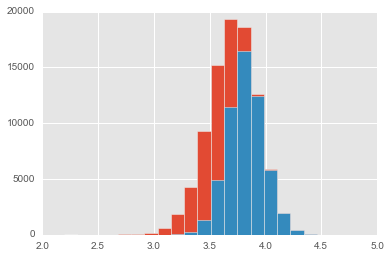

In [10]:
students["Student GPA"].hist(bins = 20)
students[students.Admitted == 1]["Student GPA"].hist(bins = 20)

Note how the student GPAs and admitted student GPAs both fall in a normal distribution with a similar shape, with the admitted GPAs shifted to the right.

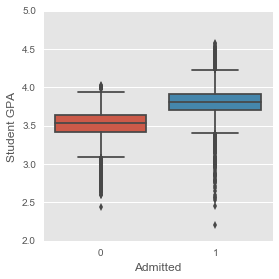

In [11]:
sns.factorplot(x = 'Admitted',
    y = 'Student GPA',
    data = students,
    kind = 'box')

Another illustration of the shape of the applicant and admitted GPAs. Note that the admitted GPA tails off rather high, and this should be fixed in a future version.

How close is our estimated student-level data to the actual data, with respect to ethnicity makeup of the incoming class?

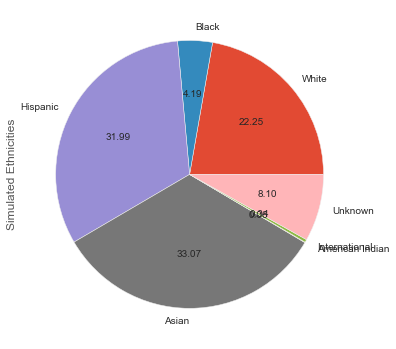

In [12]:
w = len(students[(students.Admitted == 1) & (students.White == 1)])
b = len(students[(students.Admitted == 1) & (students.Black == 1)])
h = len(students[(students.Admitted == 1) & (students.Hispanic == 1)])
a = len(students[(students.Admitted == 1) & (students.Asian == 1)])
i = len(students[(students.Admitted == 1) & (students.AmIndian == 1)])
o = len(students[(students.Admitted == 1) & (students.International == 1)])
u = len(students[(students.Admitted == 1) & (students.Unknown == 1)])

ethn = pd.Series([w, b, h, a, i, o, u], index = ["White", "Black", "Hispanic", "Asian", "American Indian", "International",\
                                                 "Unknown"], name = "Simulated Ethnicities")
ethn.plot(kind='pie', autopct='%.2f', figsize = (6, 6))

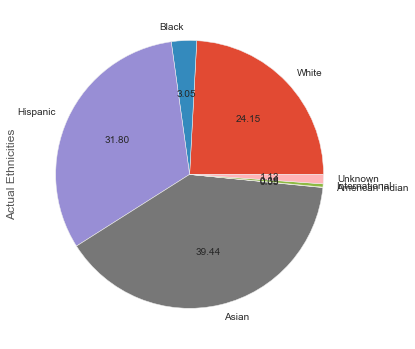

In [19]:
w = sum(admitted.White)
b = sum(admitted.Black)
h = sum(admitted.Hispanic)
a = sum(admitted.Asian)
i = sum(admitted.AmIndian)
o = sum(admitted.International)
u = sum(admitted.Unknown)

ethn_real = pd.Series([w, b, h, a, i, o, u], index = ["White", "Black", "Hispanic", "Asian", "American Indian", \
                                                      "International", "Unknown"], name = "Actual Ethnicities")
ethn_real.plot(kind='pie', autopct='%.2f', figsize = (6, 6))

In [13]:
print "Average admitted student gpa (simulated):", np.mean(students[students.Admitted == 1]["Student GPA"])
print "Average admitted student gpa (actual): ", np.mean(admitted['Adm GPA'])

Average admitted student gpa (simulated): 3.81662186153
Average admitted student gpa (actual):  3.91940818103


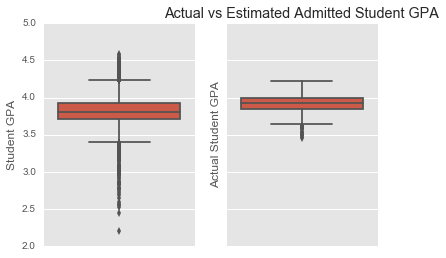

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.boxplot(y="Student GPA", data = students[students.Admitted == 1], ax=ax1)
sns.axlabel(" ", "Estimated Student GPA")
sns.boxplot(y="Adm GPA", data = admitted, ax=ax2)
sns.axlabel(" ", "Actual Student GPA")
sns.plt.title("Actual vs Estimated Admitted Student GPA")

Conclusion: The simulated data looks pretty good on ethnicities, at least on first pass. This simulation was run several times, and each time, all categories werere within 2% of the actual incoming class, with the exception of Asian students (which the model under-represents by about 6%) and "Unknown", which the model over-represents by about 7%). The student GPAs are reasonable, given that the actual GPA's are themselves averages of the GPAs within a high school.

## Income, GPA, and Admissions:

In [15]:
students[['Admitted', 'Student GPA', 'AmIndian', 'Asian', 'Black', 'Hispanic', 'International', 'White', 'Income']].corr()

,Admitted,Student GPA,AmIndian,Asian,Black,Hispanic,International,White
Admitted,1.000000,0.649467,-0.000888,0.059545,-0.020803,-0.067623,0.008837,0.018555
Student GPA,0.649467,1.000000,0.011417,0.092009,-0.066011,-0.226381,0.012555,0.189301
AmIndian,-0.000888,0.011417,1.000000,-0.016333,-0.005327,-0.017763,-0.001345,-0.012845
Asian,0.059545,0.092009,-0.016333,1.000000,-0.145631,-0.485634,-0.036768,-0.351190
Black,-0.020803,-0.066011,-0.005327,-0.145631,1.000000,-0.158379,-0.011991,-0.114533
Hispanic,-0.067623,-0.226381,-0.017763,-0.485634,-0.158379,1.000000,-0.039987,-0.381934
International,0.008837,0.012555,-0.001345,-0.036768,-0.011991,-0.039987,1.000000,-0.028917
White,0.018555,0.189301,-0.012845,-0.351190,-0.114533,-0.381934,-0.028917,1.000000


It looks like student GPA is the largest factor for admissions, followed by income (of city). We can plot these two features, together with admission decision.

In [16]:
# Ensure that the incomes are integers

students.Income = students.Income.astype('int')

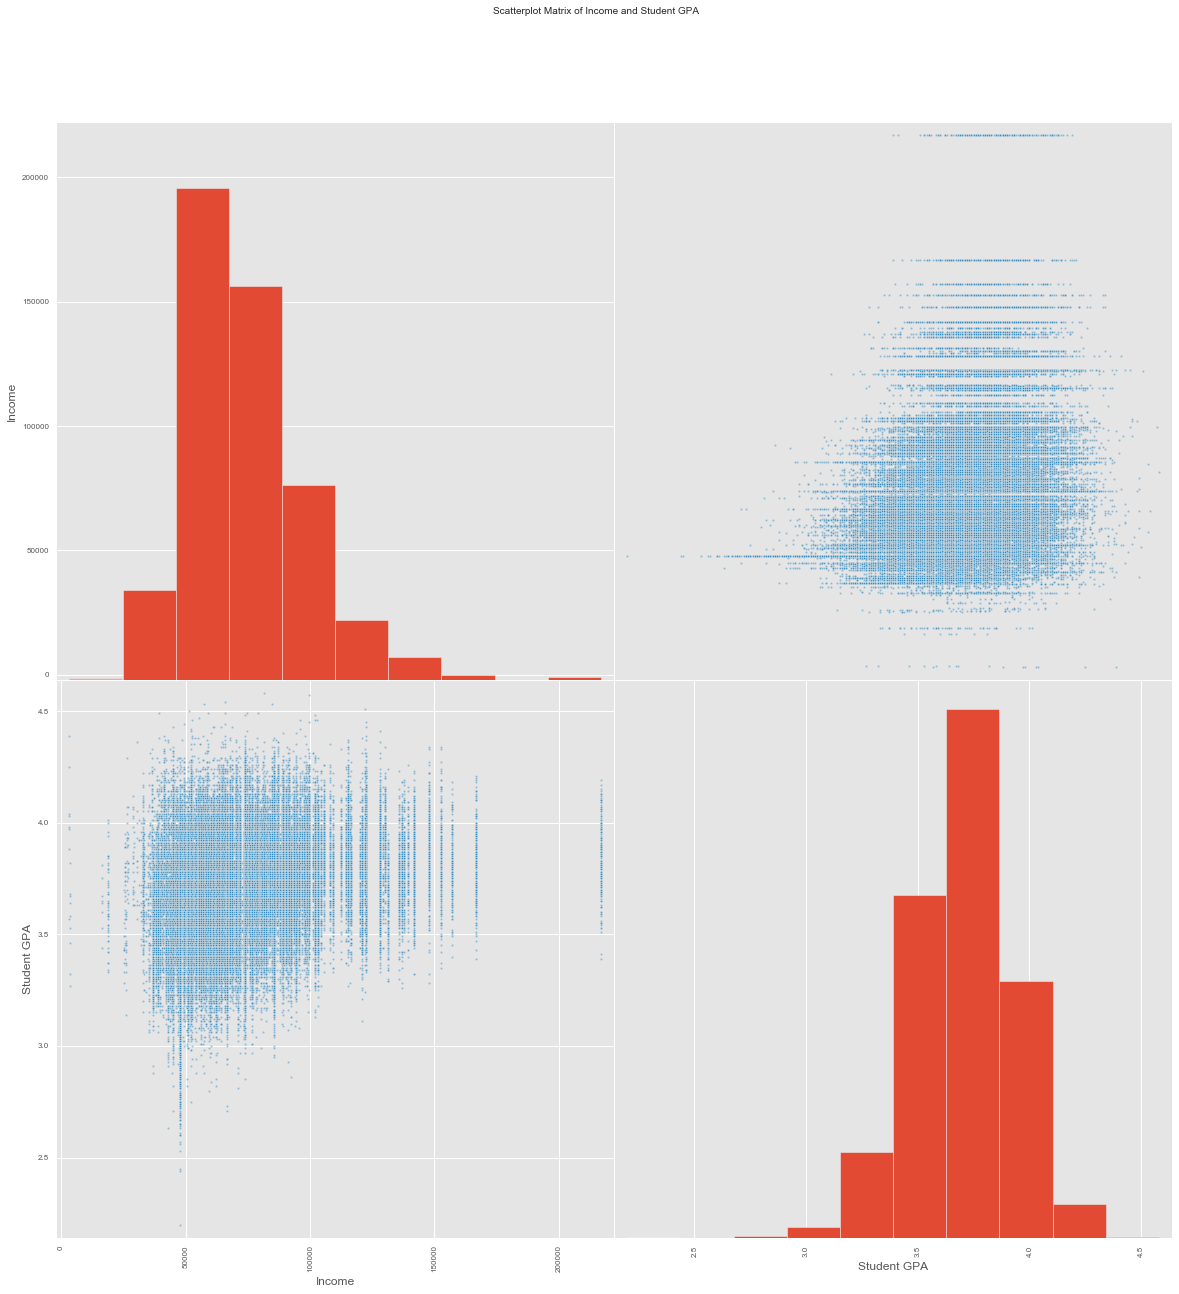

In [17]:
pd.scatter_matrix(students[['Income','Student GPA']],figsize=(20,20))
plt.suptitle('Scatterplot Matrix of Income and Student GPA')

(0.0, 250000.0)

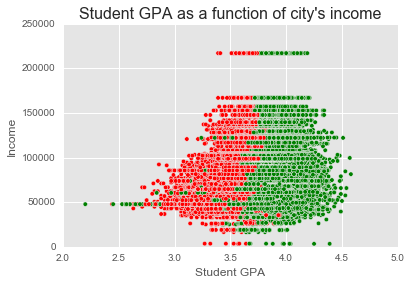

In [18]:
color = students.Admitted.map({0: 'red', 1: 'green'})
axes = students.plot('Student GPA', 'Income', kind = 'scatter', c = color)
axes.set_title("Student GPA as a function of city's income", fontsize = 16)

axes.set_xlim(2.0)

axes.set_ylim(.0)

It is obvious, looking at the X-axis, that higher GPAs result in greater admissions. Looking at the Y-axis, one can also see that admissions are slightly top-heavy, so the effect there is evident as well. It should also be noted that there is a great deal of "locality", in the sense that admits and non-admits cluster together. This suggests that KNN might be an effective model.

## To what degree do demographic factors affect admissions rates?

In [21]:
dfpcts = applicants[ ["School Name", "City", "County", "Students", "Income"] ]
dfpcts.loc[:,'Admits'] = admitted.Students

dfpcts.loc[:,"PctWhite"] = applicants.White / applicants.Students
dfpcts.loc[:,"PctAfrAm"] = applicants.Black / dfpcts.Students
dfpcts.loc[:,"PctLatino"] = applicants.Hispanic / applicants.Students
dfpcts.loc[:,"PctAsian"] = applicants.Asian / applicants.Students

dfpcts.loc[:,'Percent'] = (admitted.Students / applicants.Students)

# See note above...
dfpcts.Income = dfpcts.Income.astype(int)

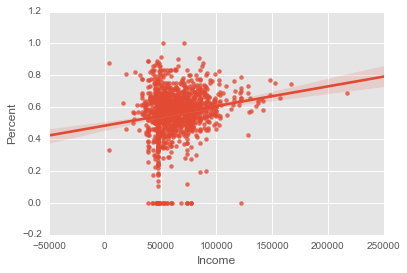

In [22]:
sns.regplot(x="Income", y="Percent", data=dfpcts)


The income of the city is positively correlated with the percentage of students who are admitted from a high school.

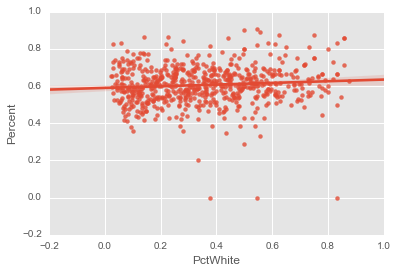

In [23]:
sns.regplot(x="PctWhite", y="Percent", data=dfpcts[dfpcts.PctWhite > 0])

The percent of students who are white is very slightly correlated with the percent of students from that HS who are admitted.

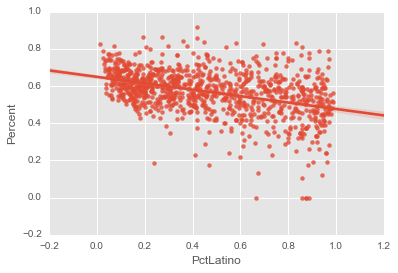

In [24]:
sns.regplot(x="PctLatino", y="Percent", data=dfpcts[dfpcts.PctLatino > 0])

The percentage of students in a school who are Latino is negatively correlated with the percentage of students who are admitted.

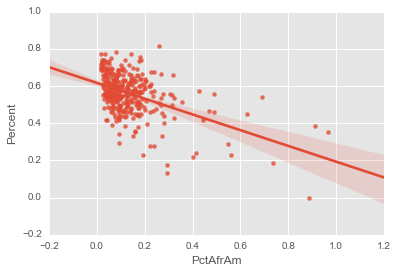

In [25]:
sns.regplot(x="PctAfrAm", y="Percent", data=dfpcts[dfpcts.PctAfrAm > 0])

The percentage of students who are African American is negatively correlated with the percentage of students who are admitted (but there is less data at the extreme end)

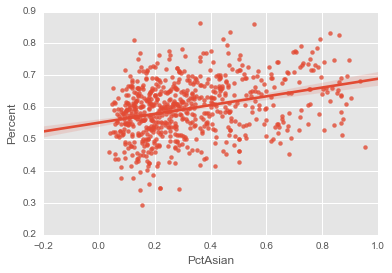

In [26]:
sns.regplot(x="PctAsian", y="Percent", data=dfpcts[dfpcts.PctAsian > 0])

The percentage of students who are Asian is positvely correlated with the percentage of students who are admitted.

Conclusion: The greater the percentage of Asian students (and, to a lesser degree, white students), the greater the acceptance rate of the high school. High schools with more Hispanic and African American students have lower acceptance rates.

## Building Models

In [27]:
# Reset the index of the student df so we get a reliable split into testing/training dfs

students.reset_index(drop=True, inplace=True)

We will add a colum here to represent normalized income. This is because median income is a 5- or 6-digit integer, while the other scalar value, GPA, is on a scale of (roughly) 0-5. This will help the logistic regression, below.

In [28]:
# Add a column of normalized student income to match the scale of GPA

maxinc = max(students.Income)
students["Income_N"] = students.Income.apply(lambda x: x / maxinc * 5)

In [29]:
# Separate the data into training and testing sets.

train_df = students.sample(frac = .6, random_state = 0)
test_df = students.drop(train_df.index)

In [30]:
# Setting the features of our model

train_X = train_df[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', 'White', 'Student GPA', 'Income']]
train_y = train_df.Admitted
test_X = test_df[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', 'White', 'Student GPA', 'Income']]
test_y = test_df.Admitted

#These are normalized versions of the training and testing data (where income is scaled)

train_X_n = train_df[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', 'White', 'Student GPA', 'Income_N']]
test_X_n = test_df[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', 'White', 'Student GPA', 'Income_N']]

## Model 1: Logistic Regression

In [31]:
logmodel = linear_model.LogisticRegression()
logmodel.fit(train_X_n, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# Score the model based on training data.
logmodel.score(train_X_n, train_y)

0.82341668355783226

In [33]:
# Score the model based on testing data.
logmodel.score(test_X_n, test_y)

0.83031592913015839

## Model 2: K Nearest Neighbors

In [34]:
knnmodel = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodel.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [35]:
cross_validation.cross_val_score(knnmodel, train_X, train_y, cv = 5).mean()


0.8768541371277434

In [36]:
knnmodel.score(test_X, test_y)

0.88399347687885232

## Model 3: Random Forest

In [37]:
rfmodel = ensemble.RandomForestClassifier(n_estimators = 1000, oob_score = True)

rfmodel.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [38]:
rfmodel.oob_score_

0.86710645119681584

In [39]:
cross_validation.cross_val_score(rfmodel, train_X, train_y, cv = 5).mean()

0.86259186427381462

In [40]:
rfmodel.score(test_X, test_y)

0.86699466541363779

All three models look promising. I'm going to focus on developing the KNN model, however, since a) it has the highest scores given the training data and b) the algorithm is relatively intuitive and straightforward.

## A closer look at the model's features

In [41]:
sorted(zip(rfmodel.feature_importances_, train_X.columns.values), reverse = True)

[(0.63944422632976416, 'Student GPA'),
 (0.34797490725160707, 'Income'),
 (0.0048162926011939, 'White'),
 (0.0033225617966992364, 'Hispanic'),
 (0.0023798257652409682, 'Asian'),
 (0.0010080125856454147, 'Unknown'),
 (0.00093292289548034622, 'Black'),
 (0.00012125077436983427, 'AmIndian')]

In [42]:
print "KNN score with income alone:"
knnmodeli = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodeli.fit(train_X[["Income"]], train_y)
print cross_validation.cross_val_score(knnmodeli, train_X["Income"].reshape(-1, 1), train_y, cv = 5).mean()

print "KNN score with GPA alone:"
knnmodelg = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodelg.fit(train_X[["Student GPA"]], train_y)
print cross_validation.cross_val_score(knnmodelg, train_X["Student GPA"].reshape(-1,1), train_y, cv = 5).mean()

print "KNN score with ethnicity alone:"
knnmodele = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodele.fit(train_X[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', 'White']], train_y)
print cross_validation.cross_val_score(knnmodele, train_X[['Black', 'AmIndian', 'Asian', 'Unknown', 'Hispanic', \
                                                           'White']], train_y, cv = 5).mean()

KNN score with income alone:
0.565147626707
KNN score with GPA alone:
0.790709416154
KNN score with ethnicity alone:
0.535209019674


It looks like the data on ethnicity and income contribute comparatively little to the model. I attempted to remove them (one at a time) to see if that would improve things; the version without ethnicity showed a clear improvement.

In [43]:
train_Xmin = train_df[['Student GPA', 'Income']]

knnmodelmin = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodelmin.fit(train_Xmin, train_y)

cross_validation.cross_val_score(knnmodelmin, train_Xmin, train_y, cv = 5).mean()

0.89430433953902744

Our cross validation score went up significantly by removing the ethnicity data!

## More on features: PCA

Maybe we can also simplify our model by reducing the number of features, but keep the (slight) contribution being made by the ethnicity data? We will implement a Principal Component Analysis to accomplish this...

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
#consider setting whiten to True above...

X_r = pca.fit(train_X).transform(train_X)

print "Explained variance ratio:", pca.explained_variance_ratio_


Explained variance ratio: [  9.99999999e-01   5.13113078e-10]


Our model will keep two components; these component seem to capture nearly all the variance...

We can also plot these new, hybrid features to see how they are distributed...

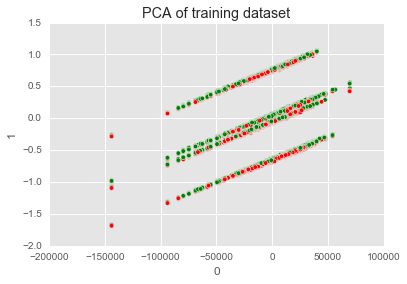

In [45]:
# Prepare the PCA object for plotting...
X_rdf = pd.DataFrame(X_r)
train_yr = train_y.reset_index(drop=True)

color = train_yr.map({0 : 'red', 1 : 'green'})
axes = X_rdf.plot(0, 1, kind = 'scatter', c = color)
axes.set_title("PCA of training dataset")



Now, we test to see how well this model does, compared to our previous KNN implementation.

In [46]:
knn_r = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knn_r.fit(X_rdf, train_yr)
print cross_validation.cross_val_score(knn_r, train_X, train_y, cv = 5).mean()

0.876854137128


Interestingly, the cross validation score is almost exactly the same as the original KNN (which incorporated data about ethnicity), though we have narrowed the model down to two features. Note that the score is still lower than the simplified version of the model without ethnicity data. For now, we'll continue to work on the simplified model, but we'll come back to the PCA version once we've finished tuning the model.

## Tuning the Model

Now, we'll use gridsearch to find the best hyperparameters for KNN. The most important parameters in the model are the number of neighbors to sample and how to weight the neighbors. The cell below will try all permutations of weights and neighbors (for k up to 20) to determine the best model, given the training data.

In [47]:
# Find the best value for k and whether weights should be uniform or distance

k_nn = range(1, 20)

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn, 'weights' : ['distance', 'uniform']},
    cv = cross_validation.KFold(len(train_df), n_folds = 10)
)

gs.fit(train_Xmin, train_y)  # Note that train_Xmin includes on GPA and income from the training DF.

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'Weights': [score.parameters['weights'] for score in gs.grid_scores_],
    'Score': [score.mean_validation_score for score in gs.grid_scores_]})

In [48]:
score_df.sort_values("Score", ascending=False)

,Score,Weights,k
20,0.897676,distance,11
36,0.897474,distance,19
24,0.897308,distance,13
28,0.897289,distance,15
34,0.897271,distance,18
...,...,...,...
37,0.886123,uniform,19
1,0.883119,uniform,1
0,0.883119,distance,1
2,0.883027,distance,2


In the current version of this notebook, the model with 15 neighbors and distance weighting does the best. Other runs, however, may result in different results, so for full generality, the final version of the model will simply use the highest score from this ranking.

In [49]:
optimal_k = score_df[score_df.Score == max(score_df.Score)].iloc[0, 2]
print optimal_k

11


## Applying the final model to the test data!

In [50]:
knnmodel = neighbors.KNeighborsClassifier(n_neighbors = optimal_k, weights = 'distance')
knnmodel.fit(train_Xmin, train_y)
cross_validation.cross_val_score(knnmodel, train_Xmin, train_y, cv = 5).mean()


0.89690247872825335

How does our model do on the testing data?

In [51]:
test_Xmin = test_df[["Student GPA", "Income"]]

knnmodel.score(test_Xmin, test_y)

0.89811769258409579

These scores are promising. We'll evaluate the model more carefully now by looking into some more advanced metrics. First, we'll look at the confusion matrix when applied to the testing data:

In [52]:
test_df["y_hat"] = knnmodel.predict(test_Xmin) 

In [53]:
print "KNN Model on Testing Data Set:"
tp = len(test_df[(test_df.Admitted == 1) & (test_df.y_hat == 1)])
fp = len(test_df[(test_df.Admitted == 0) & (test_df.y_hat == 1)])
tn = len(test_df[(test_df.Admitted == 0) & (test_df.y_hat == 0)])
fn = len(test_df[(test_df.Admitted == 1) & (test_df.y_hat == 0)])

print "True positives:", tp, "Rate (Sensitivity):", float(tp) / len(test_df[test_df.Admitted == 1])
print "False positives:", fp, "Rate (Fall-out):", float(fp) / len(test_df[test_df.Admitted == 0])
print "True negatives:", tn, "Rate:", float(tn) / len(test_df[test_df.Admitted == 0])
print "False negatives:", fn, "Rate:", float(fn) / len(test_df[test_df.Admitted == 1])

KNN Model on Testing Data Set:
True positives: 20100 Rate (Sensitivity): 0.913470278131
False positives: 1782 Rate (Fall-out): 0.125714285714
True negatives: 12393 Rate: 0.874285714286
False negatives: 1904 Rate: 0.0865297218688


We can also visualize the models' performance by looking at the ROC (Receiver Operating Curve), which plots the true positive rate against the false-positive rate -- this plot is represented in red. As the model correctly predicts admissions, the red line moves toward y=1; false positives pull the line toward x=1. They grey dashed line represents the model guessing at chance. The AUC (Area Under Curve) measures the portion of the graph beneath the red region.

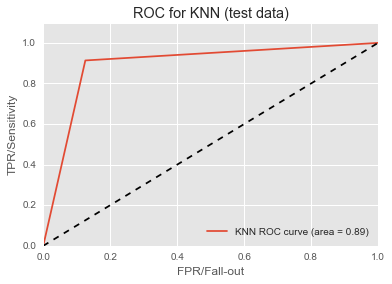

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(test_df.Admitted, test_df.y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'KNN ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("ROC for KNN (test data)")
plt.legend(loc = 'lower right')
plt.show()

## Will the PCA model help here?

In [55]:
knn_r = neighbors.KNeighborsClassifier(n_neighbors = optimal_k, weights = 'distance')
knn_r.fit(X_rdf, train_yr)
print cross_validation.cross_val_score(knn_r, train_X, train_y, cv = 5).mean()

0.877609573143


In [56]:
Xpca_test = pca.transform(test_X)

knn_r.score(Xpca_test, test_y)

0.88089775836811413

In [57]:
y_hat_pca = knn_r.predict(Xpca_test)

print "KNN / PCA Model on Testing Data Set:"
tp = len(test_df[(test_df.Admitted == 1) & (y_hat_pca == 1)])
fp = len(test_df[(test_df.Admitted == 0) & (y_hat_pca == 1)])
tn = len(test_df[(test_df.Admitted == 0) & (y_hat_pca == 0)])
fn = len(test_df[(test_df.Admitted == 1) & (y_hat_pca == 0)])

print "True positives:", tp, "Rate (Sensitivity):", float(tp) / len(test_df[test_df.Admitted == 1])
print "False positives:", fp, "Rate (Fall-out):", float(fp) / len(test_df[test_df.Admitted == 0])
print "True negatives:", tn, "Rate:", float(tn) / len(test_df[test_df.Admitted == 0])
print "False negatives:", fn, "Rate:", float(fn) / len(test_df[test_df.Admitted == 1])

KNN / PCA Model on Testing Data Set:
True positives: 19929 Rate (Sensitivity): 0.905698963825
False positives: 2234 Rate (Fall-out): 0.157601410935
True negatives: 11941 Rate: 0.842398589065
False negatives: 2075 Rate: 0.0943010361752


Unfortunately, the PCA version of the KNN model does somewhat worse than the non-PCA, simplified version of the KNN model. Its overall score is lower on testing data, and its false positive rate (which we were hoping to bring down) is higher. We not use this model.

## Conclusion

The final model is a KNN model that makes use of 15 "neighbors" and weights by distance. The inclusion of data about ethnicities reduced the accuracy of the model, so it was removed -- the model now only has two features, Student GPA and City Income. This model is also superior to a version which attempted to simplify the data by way of Principal Component Analysis. 

## To improve this model:
+ Improve income data by taking the income of the high school's zip code, rather than the whole city's zip code. 
+ Continue to tweak the simulation code to make the data more closely match the real student population.
+ Looking into variants of the model that bring down the false positive rate.